# Box Office Mojo Data

Before beginning our modeling, let's first do some initial EDA on our Box Office Mojo data.

First step though, let's import a bunch of packages!

In [36]:
import os
import pandas as pd
import numpy as np
import datetime as dt
import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
%matplotlib inline

Now let's get that data in here. We'll do some initial cleaning to start off like changing data types and adding fields such a ROI

In [6]:
fname = sorted([x for x in os.listdir('data')
                if re.match('box_office_mojo_pp', x)])[-1]
df = (pd.read_csv('data/%s' % fname)
      .set_index('title')
      .assign(release_date=lambda x: x.release_date.astype('datetime64'),
              log_gross=lambda x: np.log(x.domestic_total_gross),
              roi=lambda x: x.domestic_total_gross.div(x.budget),
              log_roi=lambda x: np.log(x.roi)))

## Features

Let's take a look at what features we have to work with.

We'll first define this cool format_cols function I often use.

It is used for two cases:
 1. For changing columns when you read in a file to make them pandorable
 2. When you output a file to make them readable

In [168]:
def format_cols(colname, direction):
    if direction == 'out':
        return (colname.replace('_', ' ')
                .title()
                .replace('Pg', 'PG')
                .replace('Roi', 'ROI')
                .replace('Wkend', 'Weekend'))
    if direction == 'in':
        return (colname.lower()
                .replace(' ', '_')
                .replace('(', '')
                .replace(')', ''))
    raise ValueError('Direction must be "in" or "out"')
string_pat = '{:<20}'
print(string_pat.format('Columns'))
print('-' * 20)
for x in df.columns.tolist():
    print(string_pat.format(format_cols(x, "out")))

Columns             
--------------------
Budget              
Domestic Total Gross
Genre               
In Release          
Open Weekend Gross  
Rating              
Release Date        
Runtime             
Widest Release      
In Release Days     
Log Gross           
Rating[T.PG]        
Rating[T.PG-13]     
Rating[T.R]         
ROI                 
Log ROI             


Looks like we have a lot of great features to work with, let's dig in!

## Release Date

In [ ]:
release_date_range = [df.release_date.min(), df.release_date.max()]
release_date_range_str = tuple([x.strftime('%B %Y') for x in release_date_range])
release_date_interval = (release_date_range[1].year - release_date_range[0].year)
print("Our movies were released between %s and %s" % release_date_range_str)
print("This is approximately a %d year range" % release_date_interval)

Let's see the distribution across years and months

In [43]:
def rotate_xticklabels(ax, rot):
    for item in ax.get_xticklabels():
        item.set_rotation(rot)

Below is the distribution across the years


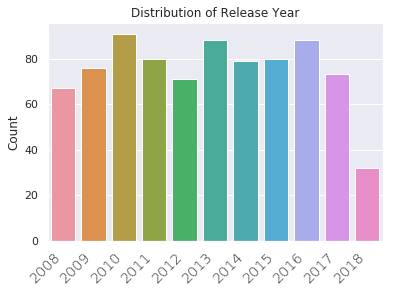

In [154]:
print("Below is the distribution across the years")
x = df.release_date.dt.year
xticks = np.sort(x.unique())
ax = sns.countplot(x)
ax.set(xlabel="", ylabel="Count", title="Distribution of Release Year")
ax.set_xticklabels(ax.get_xticklabels(), 
                   rotation=45, 
                   horizontalalignment='right',
                   fontweight='light',
                   fontsize='x-large')
plt.show()

Pretty even distribution with not as many in 2018 because that is when I repulled the data!

Below is the distribution across month


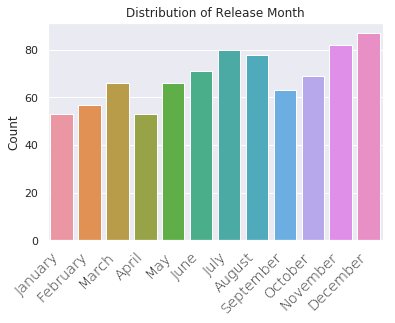

In [155]:
print("Below is the distribution across month")
x = df.release_date.dt.month
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
               'August', 'September', 'October', 'November', 'December']
xticks = np.sort(x.unique())
ax = sns.countplot(x)
ax.set(xlabel="", ylabel="Count", title="Distribution of Release Month")
ax.set_xticklabels(month_names, 
                   rotation=45, 
                   horizontalalignment='right',
                   fontweight='light',
                   fontsize='x-large')
plt.show()

Not as many movies released early in the year, but lots in July, August, November and December.

## Domestic Total Gross

Now let's take a look at domestic total gross to see how much these big movies cats are raking in.

First let's create a cool matplotlib formatter to make the x-axis play nice.

In [149]:
from matplotlib.ticker import FuncFormatter
def millions(x, pos):
    'The two args are the value and tick position'
    return '$%1.0fM' % (x*1e-6)
formatter = FuncFormatter(millions)

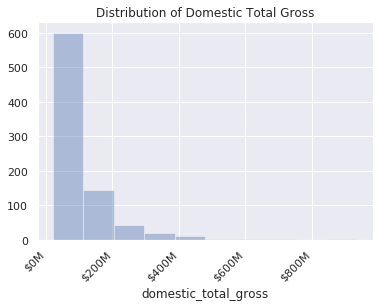

In [301]:
x = df.domestic_total_gross
ax = sns.distplot(x, kde=False, bins=10)
ax.set_xticklabels(ax.get_xticks(), 
                   rotation=45, 
                   horizontalalignment='right')
ax.set(title="Distribution of Domestic Total Gross")
ax.xaxis.set_major_formatter(formatter)
plt.show()

Woah, that's a heavy right skew if I've ever seen one!
Let's take a look at those up top.

In [181]:
(df.nlargest(25, 'domestic_total_gross')
 .assign(domestic_total_gross_millions=lambda x: x.domestic_total_gross / 1000000)
 .loc[:, ['domestic_total_gross_millions']]
 .rename(columns={'domestic_total_gross_millions': 'Domestic Total Gross (M)'})
 .applymap(lambda x: '${0:.2f}'.format(x)))

,Domestic Total Gross (M)
title,
Star Wars: The Force Awakens,$936.66
Avatar,$749.77
Marvel's The Avengers,$623.36
The Dark Knight,$533.35
Rogue One: A Star Wars Story,$532.18
Beauty and the Beast (2017),$504.01
Avengers: Age of Ultron,$459.01
The Dark Knight Rises,$448.14
The Hunger Games: Catching Fire,$424.67


There's a pretty significant drop off at 500. Let's dig into that.

In [200]:
bins = [x * 1000000 for x in range(0, 600, 100)] + [1100000000]
pd.DataFrame(pd.cut(df.domestic_total_gross, bins=bins)
             .value_counts()).sort_index()

,domestic_total_gross
"(0, 100000000]",549
"(100000000, 200000000]",189
"(200000000, 300000000]",50
"(300000000, 400000000]",20
"(400000000, 500000000]",11
"(500000000, 1100000000]",6


We can see there are only 6 entries after $500 million. Who are these studs?

In [206]:
mask = df.domestic_total_gross > 500000000
for x in df.loc[mask, ].index.tolist():
    print(x)

Beauty and the Beast (2017)
Rogue One: A Star Wars Story
Star Wars: The Force Awakens
Marvel's The Avengers
Avatar
The Dark Knight


Some pretty big names there. Not entirely suprising. Let's re-run our histogram without these movies though.

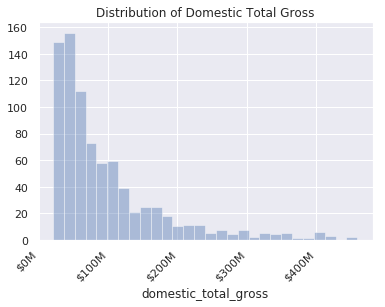

In [299]:
mask = df.domestic_total_gross < 500000000
x = df.loc[mask, 'domestic_total_gross']
ax = sns.distplot(x, kde=False)
ax.set_xticklabels(ax.get_xticks(), 
                   rotation=45, 
                   horizontalalignment='right')
ax.set(title="Distribution of Domestic Total Gross")
ax.xaxis.set_major_formatter(formatter)
plt.show()

This is look a little better and cleaner of a logrithmic distribution. Let's check out the logrithm of this.

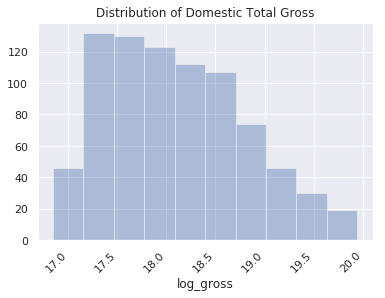

In [213]:
mask = df.domestic_total_gross < 500000000
x = df.loc[mask, 'log_gross']
ax = sns.distplot(x, kde=False, bins=10)
ax.set_xticklabels(ax.get_xticks(), 
                   rotation=45, 
                   horizontalalignment='right')
ax.set(title="Distribution of Domestic Total Gross")
plt.show()

Looks a  bit better for sure.

Let's check out domestic total gross by month and year

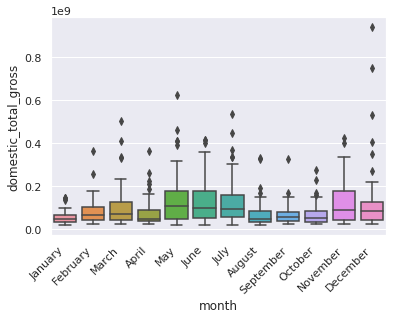

In [329]:
ax = (df.assign(month=lambda x: x.release_date.dt.month)
      .pipe((sns.boxplot, 'data'), x='month', y='domestic_total_gross'))
ax.set_xticklabels(month_names, 
                   rotation=45, 
                   horizontalalignment='right')
plt.show()

May, June, July, November and December are all the strongest months.

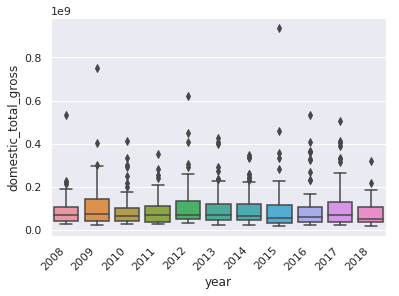

In [334]:
ax = (df.assign(year=lambda x: x.release_date.dt.year)
      .pipe((sns.boxplot, 'data'), x='year', y='domestic_total_gross'))
ax.set_xticklabels(ax.get_xticklabels(), 
                   rotation=45, 
                   horizontalalignment='right')
plt.show()

2009, 2012 and 2017 all seemed like good years for the movie industry. Usually driven by outliers though.

## Return on Investment

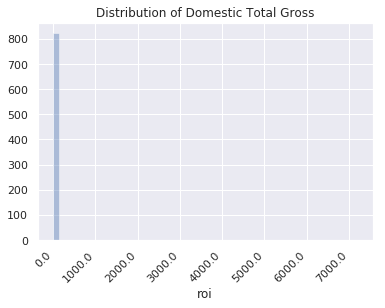

In [298]:
x = df.roi
ax = sns.distplot(x, kde=False)
ax.set_xticklabels(ax.get_xticks(), 
                   rotation=45, 
                   horizontalalignment='right')
ax.set(title="Distribution of Domestic Total Gross")
plt.show()

Holey guacamole that is a skewed distribution!

Let's check out what's going on up in here.

In [223]:
df.roi.nlargest(10)

title
Paranormal Activity      7194.587333
The Gallows               227.644100
Fireproof                  66.912634
The Devil Inside           53.261944
Get Out                    39.120148
Insidious                  36.006100
Unfriended                 32.482090
God's Not Dead             30.377866
Paranormal Activity 2      28.250969
The Last Exorcism          22.796861
Name: roi, dtype: float64

_Paranormal Activity_ absolutely crushes the competition!
After casual googling, our trustworthy source _MTV_ is able to [confirm this].

[confirm this]: http://www.mtv.com/news/1625095/paranormal-activity-is-most-profitable-film-of-all-time/

Judging from these delicious sounding titles, horror films seem to be the most profitable.
Let's see if we can prove this out.

In [226]:
(df.nlargest(15, 'roi')
 .loc[:, ['genre', 'roi']])

,genre,roi
title,,
Paranormal Activity,Horror,7194.587333
The Gallows,Horror,227.644100
Fireproof,Drama,66.912634
The Devil Inside,Horror,53.261944
Get Out,Horror,39.120148
Insidious,Horror,36.006100
Unfriended,Horror,32.482090
God's Not Dead,Drama,30.377866
Paranormal Activity 2,Horror,28.250969


There are a lot of horror films in these top movies.
We'll do some genre cleanup later on, but, for now, one more look

In [248]:
horror_genres = [x for x in list(df.genre.unique()) if 'horror' in x.lower()]
horror_mask = df.genre.isin(horror_genres)
dims = ['horror_genres']
measures = ['roi']
(df.assign(horror_genres=lambda x: x.genre.where(horror_mask, 'Non-Horror'))
 .groupby(dims)[measures].mean()
 .sort_values('roi', ascending=False)
 .applymap(lambda x: '{0:.2f}%'.format(x)))

,roi
horror_genres,
Horror,140.87%
Horror Thriller,5.58%
Sci-Fi Horror,2.20%
Non-Horror,2.13%
Horror Comedy,2.05%
Action Horror,1.24%


Let's make sure there's enough in there to make this a fair inference.

In [265]:
counts = (df.assign(horror_genres=lambda x: x.genre.where(horror_mask, 'Non-Horror'))
          .groupby(dims).size()
          .pipe(pd.DataFrame)
          .rename(columns={0: 'Count'}))
percents = (df.assign(horror_genres=lambda x: x.genre.where(horror_mask, 'Non-Horror'))
          .groupby(dims).size()
          .div(df.shape[0])
          .multiply(100)
          .pipe(pd.DataFrame)
          .applymap(lambda x: '{0:.2f}%'.format(x))
          .rename(columns={0: 'Percent of Total'}))
pd.concat([counts, percents], axis=1)

,Count,Percent of Total
horror_genres,,
Action Horror,8,0.97%
Horror,56,6.79%
Horror Comedy,7,0.85%
Horror Thriller,8,0.97%
Non-Horror,743,90.06%
Sci-Fi Horror,3,0.36%


Yup, looks like horror films crush the competition!

We'll look into genre in more depth later on.

In [296]:
bins = [x * 5 for x in range(0, 6)] + [1000]
pd.cut(df.roi, bins).value_counts()

(0, 5]        746
(5, 10]        51
(25, 1000]      8
(10, 15]        8
(15, 20]        7
(20, 25]        4
Name: roi, dtype: int64

We can remove the 8 with over a 25 percent return.

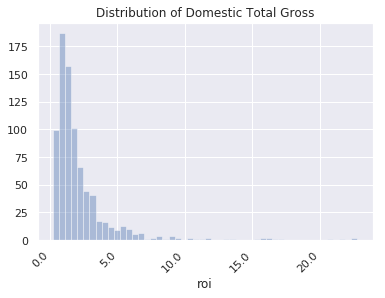

In [297]:
mask = df.roi < 25
x = df.loc[mask, 'roi']
ax = sns.distplot(x, kde=False)
ax.set_xticklabels(ax.get_xticks(), 
                   rotation=45, 
                   horizontalalignment='right')
ax.set(title="Distribution of Domestic Total Gross")
plt.show()

Let's also check out the logarithm of ROI's distribution.

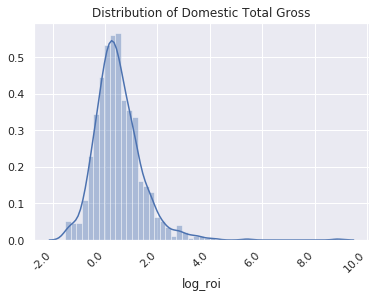

In [312]:
x = df.loc[:, 'log_roi']
ax = sns.distplot(x)
ax.set_xticklabels(ax.get_xticks(), 
                   rotation=45, 
                   horizontalalignment='right')
ax.set(title="Distribution of Domestic Total Gross")
plt.show()

Heavily right skewed, like most investment distributions.

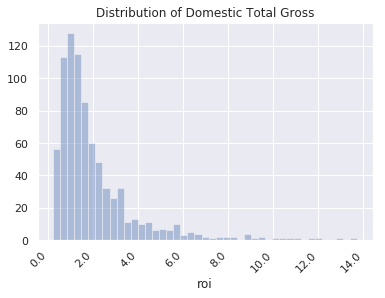

In [307]:
mask = df.roi < 15
x = df.loc[mask, 'roi']
ax = sns.distplot(x, kde=False)
ax.set_xticklabels(ax.get_xticks(), 
                   rotation=45, 
                   horizontalalignment='right')
ax.set(title="Distribution of Domestic Total Gross")
plt.show()

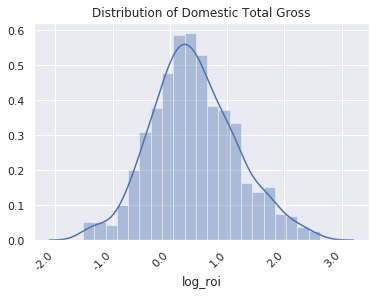

In [308]:
mask = df.roi < 15
x = df.loc[mask, 'log_roi']
ax = sns.distplot(x)
ax.set_xticklabels(ax.get_xticks(), 
                   rotation=45, 
                   horizontalalignment='right')
ax.set(title="Distribution of Domestic Total Gross")
plt.show()

In [311]:
df.loc[df.roi > 15, ].shape[0]

20

Boom, that looks pretty normally distributed!

If we remove these twenty we should be good to use Log-ROI as our dependent variables. We'll dig into these twenty to see if we can figure anything out about them later too.

Let's check with a quantile plot

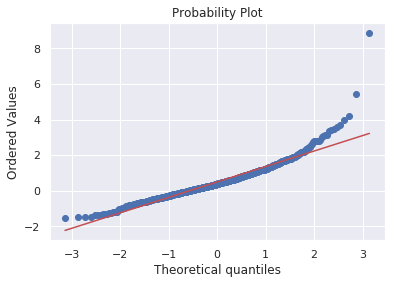

In [362]:
from scipy import stats
fig = plt.figure()
ax = fig.add_subplot(111)
stats.probplot(df.log_roi, dist="norm", plot=ax)
plt.show()

## Rating

Below is the distribution across the rating


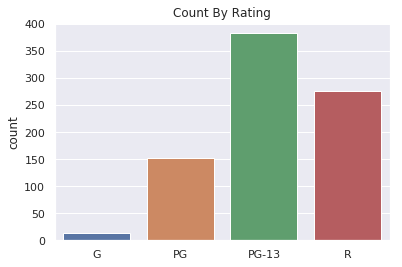

In [321]:
print("Below is the distribution across the rating")
x = df.rating
rating_order = ['G', 'PG', 'PG-13', 'R']
ax = sns.countplot(x, order=rating_order)
ax.set(xlabel="", title="Count By Rating")
plt.show()

Most are _PG-13_, with _G_ surprisingly being the least favorite for producers. Sorry kids :(

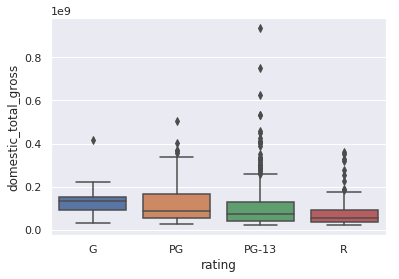

In [363]:
sns.boxplot(x='rating', y='domestic_total_gross', data=df, order=rating_order)
plt.show()

### Genre

In [233]:
print("We currently have {:d} genres in this data".format(df.genre.nunique()))

We currently have 53 genres in this data


This is way too many. Let's cut this down into subgenres and genres. 
We'll define genre from [IMDb's list here](https://www.imdb.com/feature/genre/)

In [237]:
genres = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy',
          'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Film Noir',
          'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Romance',
          'Sci-Fi', 'Sport', 'Superhero', 'Thriller', 'War', 'Western']

Below is the distribution across month


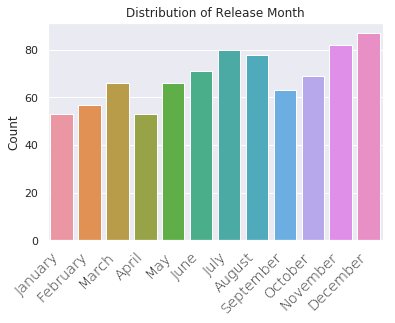

In [238]:
print("Below is the distribution across month")
x = df.release_date.dt.month
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
               'August', 'September', 'October', 'November', 'December']
xticks = np.sort(x.unique())
ax = sns.countplot(x)
ax.set(xlabel="", ylabel="Count", title="Distribution of Release Month")
ax.set_xticklabels(month_names, 
                   rotation=45, 
                   horizontalalignment='right',
                   fontweight='light',
                   fontsize='x-large')
plt.show()

## More Random Analytics Ramblings

31.14% of Total Domestic Gross is Opening Weekend Gross on Average


title
The Devil Inside                        0.633332
Friday the 13th (2009)                  0.624140
The Bye Bye Man                         0.602852
All Eyez on Me                          0.588468
Paranormal Activity: The Marked Ones    0.565073
Notorious (2009)                        0.556340
One Direction: This is Us               0.547754
Paranormal Activity 4                   0.538102
Saw V                                   0.529615
The Purge                               0.528257
dtype: float64

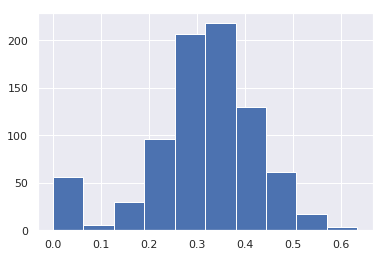

In [343]:
x = df.open_wkend_gross.div(df.domestic_total_gross).mean() * 100
print('{:,.2f}% of Total Domestic Gross is Opening Weekend '
      'Gross on Average'.format(x))
df.open_wkend_gross.div(df.domestic_total_gross).hist()
df.open_wkend_gross.div(df.domestic_total_gross).nlargest(10)

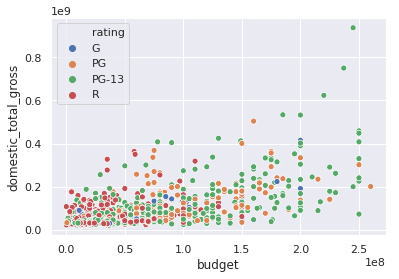

In [337]:
order = ['G', 'PG', 'PG-13', 'R']
sns.scatterplot(x='budget', y='domestic_total_gross',
                hue='rating', data=df, hue_order=order)
plt.show()

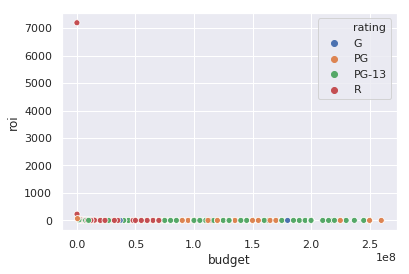

In [342]:
order = ['G', 'PG', 'PG-13', 'R']
sns.scatterplot(x='budget', y='roi',
                hue='rating', data=df, hue_order=order)
plt.show()

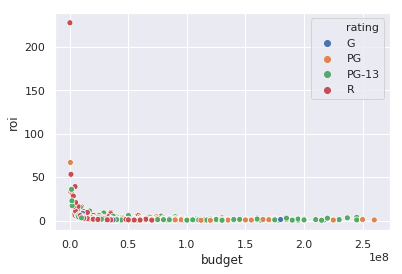

In [341]:
order = ['G', 'PG', 'PG-13', 'R']
sns.scatterplot(x='budget', y='roi', hue='rating',
                data=df.drop('Paranormal Activity'), hue_order=order)
plt.show()

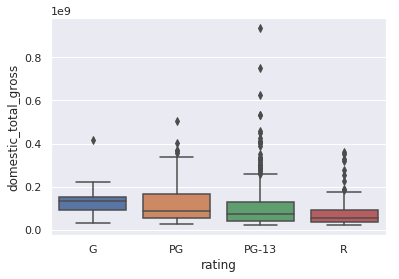

In [345]:
order = ['G', 'PG', 'PG-13', 'R']
sns.boxplot(x='rating', y='domestic_total_gross', data=df, order=order)
plt.show()

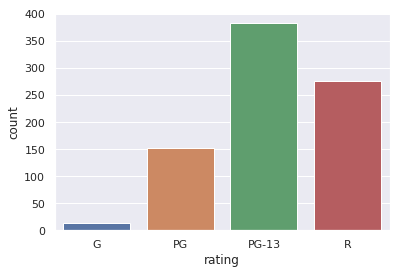

In [347]:
order = ['G', 'PG', 'PG-13', 'R']
sns.countplot(x='rating', data=df, order=order)
plt.show()

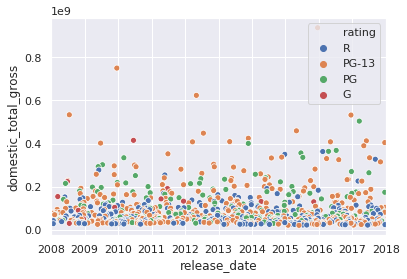

In [348]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(dt.datetime(2008, 1, 1), dt.datetime(2018, 1, 1))
sns.scatterplot(x='release_date', y='domestic_total_gross', hue='rating',
                data=df, ax=ax)
plt.show()

In [368]:
(df.loc[df.release_date.dt.year == 2009, ]
 .nlargest(1, 'domestic_total_gross')
 .loc[:, ['domestic_total_gross']])

,domestic_total_gross
title,
Avatar,749766139


In [367]:
(df.loc[df.release_date.dt.year == 2012, ]
 .nlargest(1, 'domestic_total_gross')
 .loc[:, ['domestic_total_gross']])

,domestic_total_gross
title,
Marvel's The Avengers,623357910


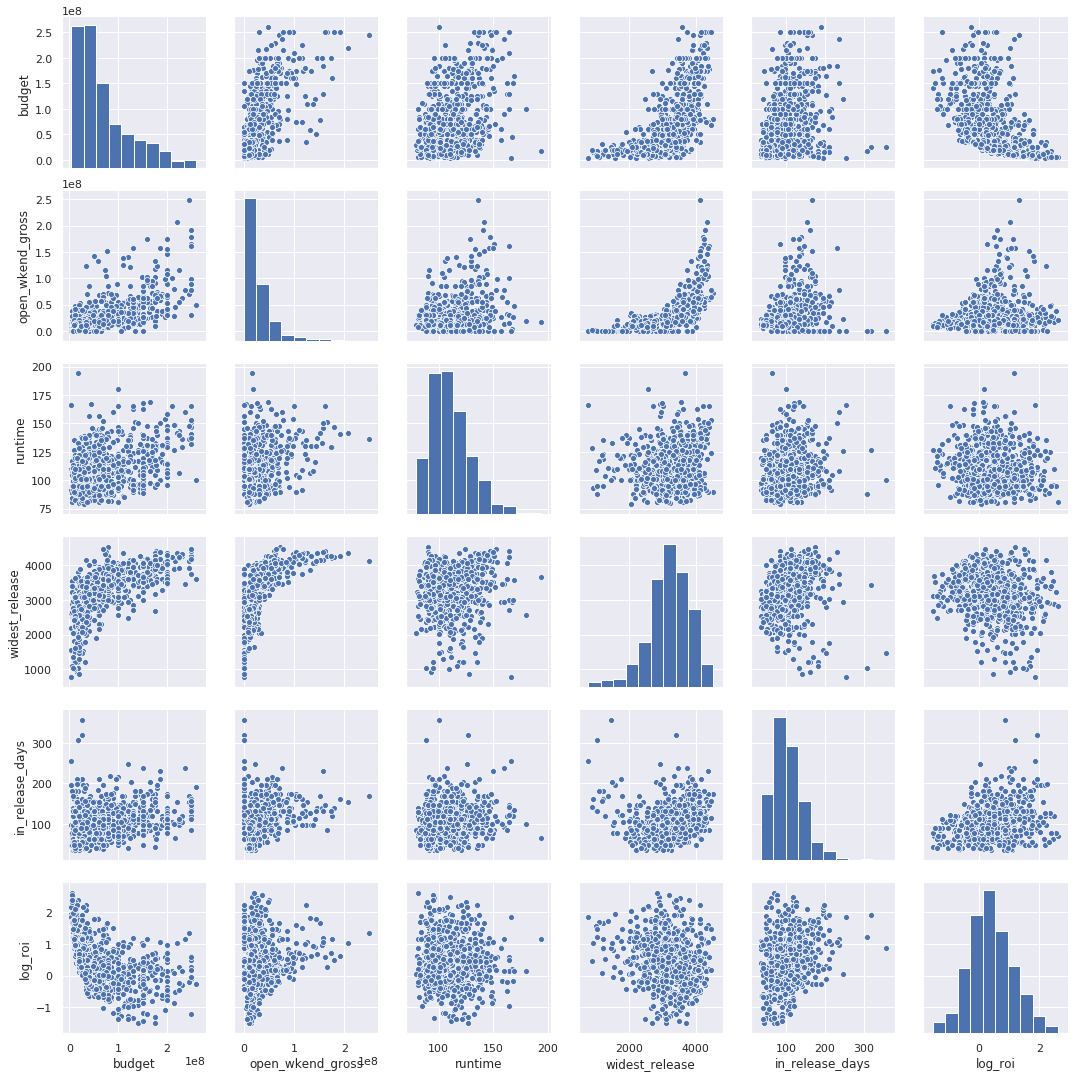

In [390]:
mask = df.roi < 15
corrcols = ['budget', 'in_release', 'open_wkend_gross', 'rating',
            'release_date', 'runtime', 'widest_release', 'in_release_days',
            'log_roi']
(df.loc[mask, corrcols]
 .pipe(sns.pairplot))
plt.show()

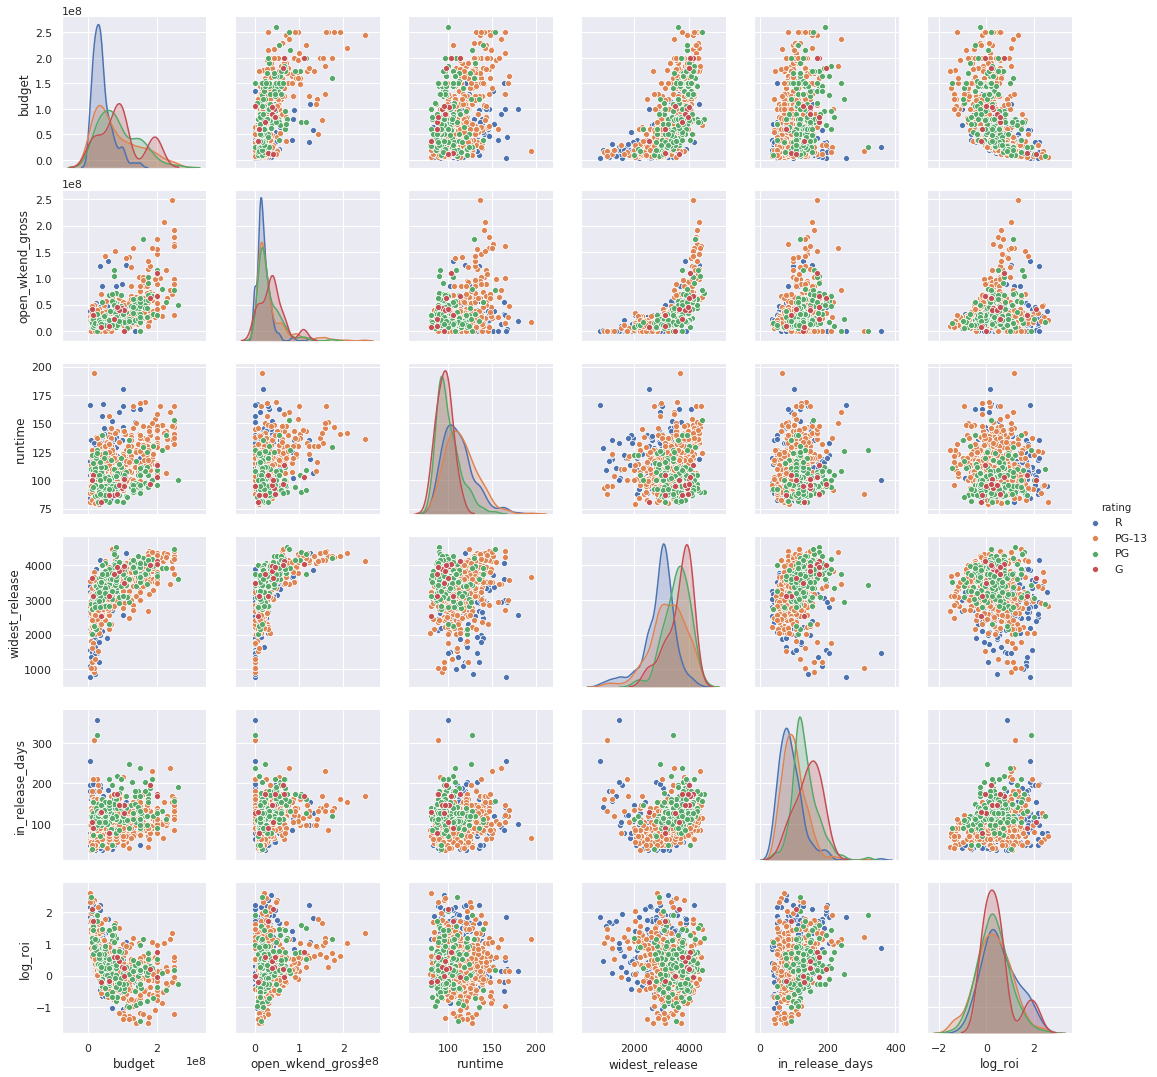

In [389]:
mask = df.roi < 15
corrcols = ['budget', 'in_release', 'open_wkend_gross', 'rating',
            'release_date', 'runtime', 'widest_release', 'in_release_days',
            'log_roi']
(df.loc[mask, corrcols]
 .pipe(sns.pairplot, hue='rating'))
plt.show()

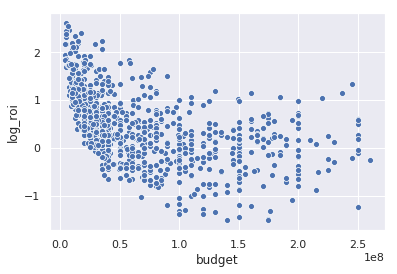

In [387]:
mask = df.roi < 15
data = (df.loc[mask, ['budget', 'log_roi']]
        .assign(budget_trans=lambda x: np.exp(x.budget)**-1))
sns.scatterplot(x='budget', y='log_roi', data=data)